In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Constant
from tensorflow.keras.initializers import RandomNormal, HeNormal, GlorotNormal
import cv2

from sklearn.model_selection import train_test_split

In [2]:
# RPI = (DO + SS + BOD + NH3N) / 4
# NH3-N / NO3-N = K  -->  NH3-N = NO3-N * K

In [3]:
def cal_RPI(DO, SS, BOD, NH3N):
    return (DO + SS + BOD + NH3N) / 4

In [4]:
APRIL_RPI = cal_RPI(9.0, 15, 0, 1.3 * 3)
MAY_RPI = cal_RPI(8.4, 10, 0, 2.5 * 3.6)
JUNE_RPI = cal_RPI(8.5, 16, 0, 1.7 * 2)
JULY_RPI = cal_RPI(6.4, 24, 0, 2.6 * 2.3)
AUGUST_RPI = cal_RPI(8.1, 143, 0, 1.2 * 2.6)
SEPTEMBER_RPI = cal_RPI(7.7, 53, 0, 1.5 * 2.4)

In [5]:
folder_paths = ['./水質檢測/Image_data/1_April',
                './水質檢測/Image_data/2_May',
                './水質檢測/Image_data/3_June',
                './水質檢測/Image_data/4_July',
                './水質檢測/Image_data/5_August',
                './水質檢測/Image_data/6_September']
labels = [APRIL_RPI, MAY_RPI, JUNE_RPI, JULY_RPI, AUGUST_RPI, SEPTEMBER_RPI]  # 对应文件夹1和文件夹2的标签

In [6]:
# Printing the calculated values
print("April RPI:", APRIL_RPI)
print("May RPI:", MAY_RPI)
print("June RPI:", JUNE_RPI)
print("July RPI:", JULY_RPI)
print("August RPI:", AUGUST_RPI)
print("September RPI:", SEPTEMBER_RPI)

April RPI: 6.975
May RPI: 6.85
June RPI: 6.975
July RPI: 9.094999999999999
August RPI: 38.555
September RPI: 16.075


In [7]:
# Since we have 2 value equal to 6.975.
# We should use 5 label to classify!

In [8]:
import tensorflow as tf
import os

def load_and_label_images(folder_path, label):
    image_paths = []  # 存储图像文件的路径
    labels = []       # 存储图像对应的标签

    # 获取文件夹中的所有图像文件的路径
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # 假设只加载jpg和png格式的图像文件
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

    # 加载图像并为其指定标签
    images = [tf.io.read_file(image_path) for image_path in image_paths]
    images = [tf.image.decode_image(image, channels=3) for image in images]

    # 可选的数据预处理：这里假设对图像进行归一化
    images = [tf.cast(image, tf.float32) / 255.0 for image in images]

    return images, labels

In [9]:
# 你可以根据需要加载多个文件夹中的图像并为其指定不同的标签
# folder_paths = ['/path/to/folder1', '/path/to/folder2']
# labels = [1, 2]  # 对应文件夹1和文件夹2的标签

# 加载所有文件夹中的图像和标签
all_images = []
all_labels = []
for folder_path, label in zip(folder_paths, labels):
    images, labels = load_and_label_images(folder_path, label)
    all_images.extend(images)
    all_labels.extend(labels)





In [10]:
unique_labels_list = list(set(all_labels))
unique_labels_list.sort()
label_to_index = {label: index for index, label in enumerate(unique_labels_list)}
label_one_hot = [tf.one_hot(label_to_index[label], len(unique_labels_list)) for label in all_labels]


In [11]:
print(len(all_images))
print(all_images[0].shape)

print(len(label_one_hot))
print(label_one_hot[0:10])

9728
(224, 224, 3)
9728
[<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>]


In [12]:

train_images, validation_images, train_labels, validation_labels = train_test_split(all_images, label_one_hot, test_size=0.2, random_state=42)
# 创建训练集数据集
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_images)).batch(batch_size=32)

# 创建验证集数据集
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels))
validation_dataset = validation_dataset.batch(batch_size=32)

In [13]:
# # 构建数据集
# dataset = tf.data.Dataset.from_tensor_slices((all_images, label_one_hot))

# # 可选的打乱和分批处理
# dataset = dataset.shuffle(buffer_size=len(all_images)).batch(batch_size=32)

In [14]:
# import matplotlib.pyplot as plt

# # 从数据集中获取并显示图像
# fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 创建一个2x5的子图布局

# for i, (image, label) in enumerate(dataset.take(10)):  # 取出前十张图像
#     row = i // 5  # 计算当前图像应该位于的行索引
#     col = i % 5   # 计算当前图像应该位于的列索引

#     axs[row, col].imshow(image[0])  # 假设每个batch里只有一张图像
#     axs[row, col].set_title('Label: {}'.format(label[0].numpy()))
#     axs[row, col].axis('off')  # 关闭坐标轴

# plt.show()

In [15]:
import tensorflow as tf

# 定义一个简单的卷积神经网络模型
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return model

In [16]:
model = create_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

/Users/future-outlier/miniconda3/envs/dev/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [17]:
# 這裡建議把epoch設小一點
# 我跑的時候差不多一個epoch要5~7分鐘

result = model.fit(train_dataset, validation_data=validation_dataset, epochs=3,verbose=1)



Epoch 1/3
244/244 ━━━━━━━━━━━━━━━━━━━━ 54s 214ms/step - accuracy: 0.3723 - loss: 1.5866 - val_accuracy: 0.6274 - val_loss: 0.8953
Epoch 2/3
244/244 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - accuracy: 0.7918 - loss: 0.6707 - val_accuracy: 0.9594 - val_loss: 0.1665
Epoch 3/3
244/244 ━━━━━━━━━━━━━━━━━━━━ 51s 208ms/step - accuracy: 0.9835 - loss: 0.0905 - val_accuracy: 0.9820 - val_loss: 0.0819


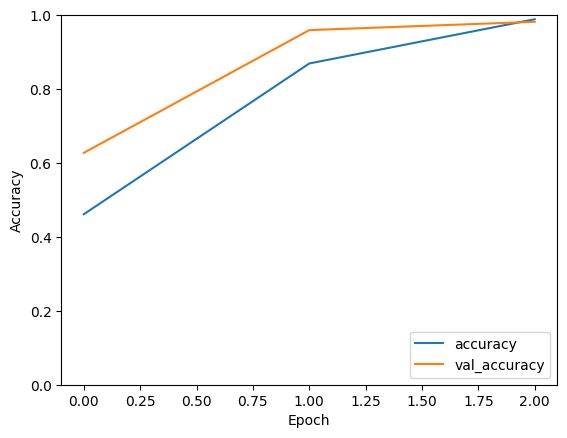

In [18]:
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


In [19]:
model.save("model.h5")

In [20]:
model = tf.keras.models.load_model('model.h5')

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix

# 使用model預測
predictions = model.predict(validation_dataset)
# 轉換成class index
predicted_classes_index = np.argmax(predictions, axis=1)
true_classes_index = np.argmax([label.numpy() for label in validation_labels], axis=1)

# 計算confusion matrix
conf_matrix = confusion_matrix(true_classes_index, predicted_classes_index)

print("Confusion Matrix:")
print(conf_matrix)

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step
Confusion Matrix:
[[416   3   1   0   0]
 [  1 604   0   0   1]
 [  1  18 346   0   3]
 [  2   1   0 205   0]
 [  0   4   0   0 340]]


In [22]:
from sklearn.metrics import roc_auc_score

predictions = np.array(predictions)
true_labels = np.array(validation_labels)
print(predictions.shape, true_labels.shape)

# 計算AUCROC
aucroc = roc_auc_score(true_labels, predictions, average='macro', multi_class='ovo')
print("AUCROC:", aucroc)

(1946, 5) (1946, 5)
AUCROC: 0.9987547434473869
